# Lab Besos Work Flow from idf to surrogate desgin optimization


In this laboratory you will go over some of the basic work flow to create a a surrogate design optimization model from an EnergyPlus simulation. You will train a surrogate model network to find optimal design parameters.

In [1]:
#!pip install besos --user
%matplotlib inline
import time
import numpy as np
import pandas as pd


from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP,EvaluatorGeneric
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem, Problem
from besos import eppy_funcs as ef, sampling

import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from plotly import express as px
import plotly

In [2]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Couldn't import dot_parser, loading of dot files will not be possible.


# Building presentation

In this Laboratory you will have to perform a surrogate optimization of a sample residential building unit. The considered unit is composed by a typical flat of a multi-storey building. Its internal organisation and definition is in line with suggested residential building typologies included in well-known architectural technical manuals  The considered building is composed by two units for floor, while a single unit is simulated for this chapter. The simulated spaces are considered to be at an intermediate floor with an upper floor and lower floor working at the same temperature (adiabatic). Similarly, the simulated unit is touching a specular one: confining walls are also assumed as adiabatic. Upper-floor balconies are included to consider shading effects.

![Image](image/building_lab.png)

## Load the Building 

The building is defined by the Information Data File (IDF) or using the new EnergyPlus format (IDF).

In [5]:
# Open the IDF file
building = ef.get_building('test_for_glazing.idf')
# building.view_model()

## Evaluator
## Set up the inputs and outputs of your exploration

- what properties of the building will we be changing?
- what are some of the performance metrics of the building that we want to explore?
- what external weather conditions is the building experiencing?


![Image](image/setting_up_the_evaluator.PNG)

### Load and Display Weather Data

In [6]:
#The weather conditions are specified in the EnergyPlus Weather File (EWP) file. The properties we will change in the building will be defined in the parameter space. In the objectives we will specify the what output performance metrics we wish to extract such that we can explore them later.

In [17]:
from epw import epw
meteo = epw()

In [18]:
epw_file='ISPATA5-hourEPW.epw'
meteo.read(epw_file)
meteo

In [19]:
meteo.dataframe

Year  Month  Day  Hour  Minute  \
0     2005      1    1     1      60   
1     2005      1    1     2      60   
2     2005      1    1     3      60   
3     2005      1    1     4      60   
4     2005      1    1     5      60   
...    ...    ...  ...   ...     ...   
8755  2005     12   31    20      60   
8756  2005     12   31    21      60   
8757  2005     12   31    22      60   
8758  2005     12   31    23      60   
8759  2005     12   31    24      60   

                 Data Source and Uncertainty Flags  Dry Bulb Temperature  \
0     *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  14.5   
1     *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  14.0   
2     *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  13.5   
3     *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  13.2   
4     *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  13.0   
...                                            ...                   ...   
8755  *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  11.1   
8756  *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  10.8   
8757  *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                  10.3   
8758  *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                   9.8   
8759  *?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?                   8.8   

      Dew Point Temperature  Relative Humidity  Atmospheric Station Pressure  \
0                       8.3                 66                         99760   
1                       8.3                 69                         99760   
2                       7.8                 68                         99760   
3                       7.6                 68                         99760   
4                       7.3                 68                         99760   
...                     ...                ...                           ...   
8755                   10.5                 96                         99185   
8756                   10.2                 96                         99210   
8757                   10.0                 98                         99236   
8758                    9.4                 98                         99261   
8759                    8.6                 98                         99287   

      ...  Ceiling Height  Present Weather Observation  Present Weather Codes  \
0     ...           77777                            9              999999999   
1     ...           77777                            9              999999999   
2     ...           77777                            9              999999999   
3     ...           77777                            9              999999999   
4     ...           77777                            9              999999999   
...   ...             ...                          ...                    ...   
8755  ...           77777                            9              999999999   
8756  ...           77777                            9              999999999   
8757  ...           77777                            9              999999999   
8758  ...           77777                            9              999999999   
8759  ...           77777                            9              999999999   

      Precipitable Water  Aerosol Optical Depth  Snow Depth  \
0                     17                  0.108           0   
1                     17                  0.108           0   
2                     16                  0.108           0   
3                     16                  0.108           0   
4                     15                  0.108           0   
...                  ...                    ...         ...   
8755                  19                  0.122           0   
8756                  19                  0.122           0   
8757                  19                  0.122           0   
8758                  18                  0.122 

In [20]:
meteo.dataframe.describe()

Year        Month          Day         Hour  Minute  \
count  8760.0  8760.000000  8760.000000  8760.000000  8760.0   
mean   2005.0     6.526027    15.720548    12.500000    60.0   
std       0.0     3.448048     8.796749     6.922582     0.0   
min    2005.0     1.000000     1.000000     1.000000    60.0   
25%    2005.0     4.000000     8.000000     6.750000    60.0   
50%    2005.0     7.000000    16.000000    12.500000    60.0   
75%    2005.0    10.000000    23.000000    18.250000    60.0   
max    2005.0    12.000000    31.000000    24.000000    60.0   

       Dry Bulb Temperature  Dew Point Temperature  Relative Humidity  \
count           8760.000000            8760.000000        8760.000000   
mean              18.234532               9.490491          59.713699   
std                7.960274               5.000869          17.111015   
min               -0.700000              -5.600000          18.000000   
25%               12.000000               5.900000          46.000000   
50%               17.500000               9.800000          60.000000   
75%               24.500000              13.000000          72.250000   
max               39.600000              23.300000         100.000000   

       Atmospheric Station Pressure  Extraterrestrial Horizontal Radiation  \
count                   8760.000000                            8760.000000   
mean                   99635.897831                             336.882763   
std                      226.611524                             421.915789   
min                    98830.000000                               0.000000   
25%                    99523.000000                               0.000000   
50%                    99688.000000                              18.000000   
75%                    99791.000000                             686.000000   
max                   100135.000000                            1280.000000   

       ...  Ceiling Height  Present Weather Observation  \
count  ...          8760.0                       8760.0   
mean   ...         77777.0                          9.0   
std    ...             0.0                          0.0   
min    ...         77777.0                          9.0   
25%    ...         77777.0                          9.0   
50%    ...         77777.0                          9.0   
75%    ...         77777.0                          9.0   
max    ...         77777.0                          9.0   

       Present Weather Codes  Precipitable Water  Aerosol Optical Depth  \
count                 8760.0         8760.000000            8760.000000   
mean             999999999.0           19.148973               0.140995   
std                      0.0            6.714903               0.039329   
min              999999999.0            6.000000               0.041000   
25%              999999999.0           14.000000               0.109000   
50%              999999999.0           18.000000               0.141000   
75%              999999999.0           23.000000               0.169000   
max              999999999.0           47.000000               0.257000   

       Snow Depth  Days Since Last Snowfall        Albedo  \
count      8760.0               8760.000000  8.760000e+03   
mean          0.0                 50.905822  2.000000e-01   
std           0.0                 38.190005  2.775716e-17   
min           0.0                  0.000000  2.000000e-01   
25%           0.0                  7.000000  2.000000e-01   
50%           0.0                 66.000000  2.000000e-01   
75%           0.0                 88.000000  2.000000e-01   
max           0.0                 88.000000  2.000000e-01   

       Liquid Precipitation Depth  Liquid Precipitation Quantity  
count                 8760.000000                         8760.0  
mean                     0.038390                           99.0  
std                      0.331506                            0.0  
min                      0.000000            

# Define The Problem

1. Define the parameters and your objectives you whant to change
2. Create Selectors for getting the paramters fileds in the model
3. Describe the parameter variation
4. Define your problem

In [21]:
building.idfobjects

{'VERSION': [
 Version,
     9.6;                      !- Version Identifier
 ],
 'SIMULATIONCONTROL': [
 SimulationControl,
     Yes,                      !- Do Zone Sizing Calculation
     Yes,                      !- Do System Sizing Calculation
     No,                       !- Do Plant Sizing Calculation
     No,                       !- Run Simulation for Sizing Periods
     Yes,                      !- Run Simulation for Weather File Run Periods
     ,                         !- Do HVAC Sizing Simulation for Sizing Periods
     ;                         !- Maximum Number of HVAC Sizing Simulation Passes
 ],
 'PERFORMANCEPRECISIONTRADEOFFS': [],
 'BUILDING': [
 Building,
     Building,                 !- Name
     0,                        !- North Axis
     Suburbs,                  !- Terrain
     0.04,                     !- Loads Convergence Tolerance Value
     0.4,                      !- Temperature Convergence Tolerance Value
     FullExterior,             !- Solar Distri

In [22]:
for class_name,idfobject in building.idfobjects.items():
    if len(idfobject)>0:
        print(class_name)

VERSION
SIMULATIONCONTROL
BUILDING
SHADOWCALCULATION
SURFACECONVECTIONALGORITHM:INSIDE
SURFACECONVECTIONALGORITHM:OUTSIDE
HEATBALANCEALGORITHM
ZONEAIRCONTAMINANTBALANCE
ZONECAPACITANCEMULTIPLIER:RESEARCHSPECIAL
TIMESTEP
CONVERGENCELIMITS
SITE:LOCATION
SIZINGPERIOD:DESIGNDAY
RUNPERIOD
RUNPERIODCONTROL:SPECIALDAYS
RUNPERIODCONTROL:DAYLIGHTSAVINGTIME
SITE:GROUNDTEMPERATURE:BUILDINGSURFACE
SITE:GROUNDTEMPERATURE:FCFACTORMETHOD
SITE:GROUNDTEMPERATURE:SHALLOW
SITE:GROUNDTEMPERATURE:DEEP
SITE:GROUNDREFLECTANCE
SITE:GROUNDREFLECTANCE:SNOWMODIFIER
SCHEDULETYPELIMITS
SCHEDULE:DAY:HOURLY
SCHEDULE:DAY:INTERVAL
SCHEDULE:DAY:LIST
SCHEDULE:WEEK:DAILY
SCHEDULE:YEAR
SCHEDULE:COMPACT
MATERIAL
MATERIAL:NOMASS
MATERIAL:INFRAREDTRANSPARENT
WINDOWMATERIAL:GLAZING
WINDOWMATERIAL:GAS
WINDOWMATERIAL:BLIND
CONSTRUCTION
GLOBALGEOMETRYRULES
ZONE
BUILDINGSURFACE:DETAILED
FENESTRATIONSURFACE:DETAILED
WINDOWSHADINGCONTROL
WINDOWPROPERTY:FRAMEANDDIVIDER
SHADING:SITE:DETAILED
SHADING:BUILDING:DETAILED
PEOPLE
LIGHTS
OT

In [23]:
building.idfobjects["MATERIAL"]

[
Material,
    MW Glass Wool (high performance panels)_.02,    !- Name
    Rough,                    !- Roughness
    0.02,                     !- Thickness
    0.032,                    !- Conductivity
    30,                       !- Density
    840,                      !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
, 
Material,
    Concrete blocks/tiles - block lightweight 300mm_.24,    !- Name
    Rough,                    !- Roughness
    0.24,                     !- Thickness
    0.73,                     !- Conductivity
    1800,                     !- Density
    840,                      !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
, 
Material,
    Mineral fibre/wool - wool_.05,    !- Name
    Rough,                    !- R

In [24]:
for materials in building.idfobjects["MATERIAL"]:
     print("{} - {}[m]".format(materials.Name,materials.Thickness))

MW Glass Wool (high performance panels)_.02 - 0.02[m]
Concrete blocks/tiles - block lightweight 300mm_.24 - 0.24[m]
Mineral fibre/wool - wool_.05 - 0.05[m]
Aerated Concrete Slab_.06 - 0.06[m]
Ceramic/porcelain_.02 - 0.02[m]
Ceramic glazed_.005 - 0.005[m]
Mortar_.01 - 0.01[m]
Brickwork Inner_.09 - 0.09[m]
Gypsum Plastering_.015 - 0.015[m]
Masonry - block lightweight_.17 - 0.17[m]
Steel_.003 - 0.003[m]
XPS Extruded Polystyrene  - CO2 Blowing_.35 - 0.35[m]
Concrete Block (Medium)_.2 - 0.2[m]
Cast Concrete_.2 - 0.2[m]
Gypsum Plastering_.05 - 0.05[m]
Mortar_.045 - 0.045[m]
Ceramic/porcelain_.005 - 0.005[m]
Cement/plaster/mortar - cement plaster_.025 - 0.025[m]
Gypsum Plastering_.025 - 0.025[m]
Mortar_.02 - 0.02[m]


In [25]:
roof_ins = FieldSelector(class_name='Material',
                         object_name='MW Glass Wool (high performance panels)_.02',
                         field_name='Thickness')
wall_ins = FieldSelector(class_name='Material', 
                         object_name='XPS Extruded Polystyrene  - CO2 Blowing_.35', 
                         field_name='Thickness')

In [26]:
wall_range = RangeParameter(min_val=0.1,max_val=0.5)
roof_range = RangeParameter(min_val=0.01,max_val=0.1)

We can combine this with the `Selector` above to get a `Parameter`:

In [27]:
insulation_param = [Parameter(selector=wall_ins,
                                 value_descriptor=wall_range ,
                                 name='Wall Insulation'),
                   Parameter(selector=roof_ins,
                                 value_descriptor=roof_range ,
                                 name='Roof Insulation')
                   ]
print(insulation_param)


[Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_.35'), value_descriptors=[RangeParameter(min=0.1, max=0.5)]), Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='MW Glass Wool (high performance panels)_.02'), value_descriptors=[RangeParameter(min=0.01, max=0.1)])]


/home/ict4bd/ict4bd/lib/python3.8/site-packages/besos/parameters.py:424: FutureWarning: Use value_descriptors instead of value_descriptor.
  warnings.warn(


In [28]:
[window for window in building.idfobjects['FENESTRATIONSURFACE:DETAILED'] if window.Surface_Type=='Window']

[
 FenestrationSurface:Detailed,
     F01:Toileta_Wall_7_0_0_0_0_0_Win,    !- Name
     Window,                   !- Surface Type
     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001,    !- Construction Name
     F01:Toileta_Wall_7_0_0,    !- Building Surface Name
     ,                         !- Outside Boundary Condition Object
     AutoCalculate,            !- View Factor to Ground
     1,                        !- Frame and Divider Name
     1,                        !- Multiplier
     4,                        !- Number of Vertices
     -19.2921472523,           !- Vertex 1 Xcoordinate
     -31.3799979636,           !- Vertex 1 Ycoordinate
     5.55,                     !- Vertex 1 Zcoordinate
     -24.3739835487,           !- Vertex 2 Xcoordinate
     -32.0039690018,           !- Vertex 2 Ycoordinate
     5.55,                     !- Vertex 2 Zcoordinate
     -24.3739835487,           !- Vertex 3 Xcoordinate
     -32.0039690018,           !- Vertex 3 Ycoordinate
     6.33,              

In [29]:
windows = FieldSelector(class_name='FenestrationSurface:Detailed', 
                        object_name='*',
                        field_name='Construction Name')

In [30]:
windows.get_objects(building)

[
FenestrationSurface:Detailed,
    F01:Toileta_Partition_6_0_0_0_0_0_Door,    !- Name
    Door,                     !- Surface Type
    Metal door,               !- Construction Name
    F01:Toileta_Partition_6_0_0,    !- Building Surface Name
    F01:Corridors_Partition_14_0_0_0_0_0_Door_10012,    !- Outside Boundary Condition Object
    0,                        !- View Factor to Ground
    ,                         !- Frame and Divider Name
    1,                        !- Multiplier
    4,                        !- Number of Vertices
    -18.7544640109,           !- Vertex 1 Xcoordinate
    -32.8050933058,           !- Vertex 1 Ycoordinate
    3.75,                     !- Vertex 1 Zcoordinate
    -18.8738959674,           !- Vertex 2 Xcoordinate
    -31.8323980772,           !- Vertex 2 Ycoordinate
    3.75,                     !- Vertex 2 Zcoordinate
    -18.8738959674,           !- Vertex 3 Xcoordinate
    -31.8323980772,           !- Vertex 3 Ycoordinate
    5.85,              

In [31]:
#selection of windows parameters
win_arr = ['Sgl Clr 6mm - 1001', 'Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001',\
          'Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001']
# 'Sgl Clr 6mm - 1001','Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001',\
#            ,'Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001'
windowsTypes = CategoryParameter(win_arr)      
windowsTypes

CategoryParameter(options=['Sgl Clr 6mm - 1001', 'Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001', 'Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001'])

In [32]:
windowsParameters = []

for fenestration in building.idfobjects["FenestrationSurface:Detailed"]:
     if fenestration.obj[2] == "Window":
        sel = FieldSelector(class_name ='FenestrationSurface:Detailed', 
                            object_name = fenestration.Name, 
                            field_name='Construction Name' )
        windowsParameters.append(Parameter(selector=sel, 
                                           value_descriptors = windowsTypes, 
                                           name='Windows types'))

/home/ict4bd/ict4bd/lib/python3.8/site-packages/besos/parameters.py:441: UserWarning: This parameter's descriptor is already named Windows types.The name used as an input (Windows types) will be discarded.
  warnings.warn(


In [33]:
windowsParameters

[Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='F01:Toileta_Wall_7_0_0_0_0_0_Win'), value_descriptors=[CategoryParameter(options=['Sgl Clr 6mm - 1001', 'Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001', 'Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001'])]),
 Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='F01:Toileta_Wall_8_0_0_0_0_1_Win'), value_descriptors=[CategoryParameter(options=['Sgl Clr 6mm - 1001', 'Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001', 'Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001'])]),
 Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='F01:Toileta_Wall_8_0_0_1_0_0_Win'), value_descriptors=[CategoryParameter(options=['Sgl Clr 6mm - 1001', 'Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001', 'Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001'])]),
 Parameter(selector=FieldSelector(field_nam

In [34]:
#ACH parameters selection
ventAchRange = RangeParameter(min_val = 0.0, max_val=6.0)

ventilationAchParam = []


ventACH_sel = FieldSelector(class_name = 'ZoneVentilation:DesignFlowRate', 
                    object_name = '*', 
                    field_name = 'Air Changes per Hour')
ventilationAchParam.append(Parameter(selector=ventACH_sel, 
                                     value_descriptors=ventAchRange, 
                                     name='Ventilation ACH'))


In [35]:
ventilationAchParam

[Parameter(selector=FieldSelector(field_name='Air Changes per Hour', class_name='ZoneVentilation:DesignFlowRate', object_name='*'), value_descriptors=[RangeParameter(min=0.0, max=6.0)])]

In [36]:
lights_selector = FieldSelector(class_name='Lights', object_name='*', field_name='Watts per Zone Floor Area')
lights_range = RangeParameter(min_val=15,max_val=30)

In [37]:
lights_param =     Parameter(
        lights_selector,
        value_descriptor=lights_range ,
        name="Lights Watts/Area",
    )

In [38]:
[shadeControl for shadeControl in building.idfobjects["WINDOWSHADINGCONTROL"]]

[
 WindowShadingControl,
     11003,                    !- Name
     F01:Classa,               !- Zone Name
     ,                         !- Shading Control Sequence Number
     ExteriorBlind,            !- Shading Type
     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 2003,    !- Construction with Shading Name
     OnIfHighOutdoorAirTempAndHighHorizontalSolar,    !- Shading Control Type
     D1_Edu_ClassRm_Occ,       !- Schedule Name
     26,                       !- Setpoint
     Yes,                      !- Shading Control Is Scheduled
     No,                       !- Glare Control Is Active
     ,                         !- Shading Device Material Name
     FixedSlatAngle,           !- Type of Slat Angle Control for Blinds
     ,                         !- Slat Angle Schedule Name
     160,                      !- Setpoint 2
     ,                         !- Daylighting Control Object Name
     Group,                    !- Multiple Surface Control Type
     F01:Classa_Wall_7_0_0_0_0_5_Win,

In [39]:
TempShadingRange = RangeParameter(min_val = 18, max_val=30)
RadShadingRange = RangeParameter(min_val = 80, max_val=300)

setpointParams = []
shade_setpoint_sel = FieldSelector(class_name ='WindowShadingControl', 
                    object_name = '*', 
                    field_name='Setpoint' )
shade_setpoint2_sel = FieldSelector(class_name ='WindowShadingControl', 
                     object_name = '*', 
                     field_name='Setpoint 2' )
setpointParams.append(Parameter(selector=shade_setpoint_sel, value_descriptor = TempShadingRange, name='Temp Setpoint shading'))
setpointParams.append(Parameter(selector=shade_setpoint2_sel, value_descriptor = RadShadingRange, name='Rad Setpoint shading'))

In [40]:
shadarr = ['Sgl Clr 6mm - 2003', 'Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 2003',\
           'Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 2003']
shadingwindow = CategoryParameter(shadarr)  
shadingwindowParams = []
shadewindow = FieldSelector(class_name ='WindowShadingControl', 
                    object_name = '*', 
                    field_name='Construction with Shading Name' )
shadingwindowParams.append(Parameter(selector=shadewindow, value_descriptor = shadingwindow, name='ShadingWindowType'))

In [41]:
parameters = insulation_param + windowsParameters + [lights_param] + ventilationAchParam + setpointParams + shadingwindowParams

In [42]:
parameters

[Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_.35'), value_descriptors=[RangeParameter(min=0.1, max=0.5)]),
 Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='MW Glass Wool (high performance panels)_.02'), value_descriptors=[RangeParameter(min=0.01, max=0.1)]),
 Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='F01:Toileta_Wall_7_0_0_0_0_0_Win'), value_descriptors=[CategoryParameter(options=['Sgl Clr 6mm - 1001', 'Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001', 'Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001'])]),
 Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='F01:Toileta_Wall_8_0_0_0_0_1_Win'), value_descriptors=[CategoryParameter(options=['Sgl Clr 6mm - 1001', 'Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001', 'Trp LoE (e2=e5=.1)

In [43]:
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`

problem=EPProblem(parameters, objectives) # problem = parameters + objectives



In [82]:
problem.names()

['Wall Insulation',
 'Roof Insulation',
 'Windows types',
 'Lights Watts/Area',
 'Ventilation ACH',
 'Temp Setpoint shading',
 'Rad Setpoint shading',
 'ShadingWindowType',
 'Electricity:Facility',
 'DistrictHeating:Facility',
 'DistrictCooling:Facility']

## Generate the Dataset

1. Generate 10 samples with sampling strategy
2. Setup the parallel processing
3. Simulate the Samples
4. Store and recover the expensive runs

In [83]:
samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=200)
samples

Wall Insulation  Roof Insulation  \
0           0.260621         0.061127   
1           0.355875         0.040835   
2           0.356674         0.089459   
3           0.303657         0.030852   
4           0.316898         0.043995   
..               ...              ...   
195         0.489221         0.068806   
196         0.242352         0.021287   
197         0.223521         0.049357   
198         0.328936         0.096763   
199         0.245545         0.059242   

                                  Windows types  Lights Watts/Area  \
0       Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          24.990030   
1                            Sgl Clr 6mm - 1001          16.311551   
2    Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          20.731484   
3       Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          23.138816   
4    Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          18.204054   
..                                          ...                ...   
195  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          27.864041   
196     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          22.284171   
197     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          18.275140   
198  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          24.893853   
199                          Sgl Clr 6mm - 1001          23.719163   

     Ventilation ACH  Temp Setpoint shading  Rad Setpoint shading  \
0           1.528347              21.023609            285.974930   
1           0.690665              20.788850            242.440963   
2           3.830194              25.759114            201.404449   
3           2.244949              21.670946             90.831564   
4           2.807581              28.123548            174.301830   
..               ...                    ...                   ...   
195         1.840539              27.146057            122.019198   
196         4.342160              28.832793            209.418125   
197         5.272548              26.460344            120.402558   
198         5.831155              20.509200            296.503723   
199         0.878693              22.514369            158.478869   

                              ShadingWindowType  
0                            Sgl Clr 6mm - 2003  
1    Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 2003  
2       Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 2003  
3                            Sgl Clr 6mm - 2003  
4       Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 2003  
..                                          ...  
195                          Sgl Clr 6mm - 2003  
196                          Sgl Clr 6mm - 2003  
197  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 2003  
198  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 2003  
199  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 2003  

[200 rows x 8 columns]

In [84]:
samples = samples[samples['Windows types'].str[:3] == samples['ShadingWindowType'].str[:3]]
samples

Wall Insulation  Roof Insulation  \
7           0.227517         0.017198   
10          0.186016         0.083834   
12          0.403764         0.041921   
14          0.207772         0.015768   
16          0.237008         0.080736   
..               ...              ...   
180         0.429130         0.076601   
186         0.431093         0.053319   
188         0.477294         0.064135   
193         0.423806         0.057433   
198         0.328936         0.096763   

                                  Windows types  Lights Watts/Area  \
7                            Sgl Clr 6mm - 1001          21.381945   
10   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          22.440241   
12      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          26.918016   
14                           Sgl Clr 6mm - 1001          26.687891   
16   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          15.875133   
..                                          ...                ...   
180  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          23.213153   
186     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          19.775193   
188     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          17.966045   
193     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          25.143783   
198  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          24.893853   

     Ventilation ACH  Temp Setpoint shading  Rad Setpoint shading  \
7           4.784007              24.023131             97.586483   
10          4.945772              27.737622            136.497563   
12          0.409817              21.991878             85.450229   
14          2.523621              24.461977            179.646914   
16          0.348876              26.948971             87.800237   
..               ...                    ...                   ...   
180         0.594820              20.711598            116.221796   
186         2.566943              23.725175             92.043839   
188         3.113050              26.256466            109.267907   
193         1.717973              20.597582            168.699966   
198         5.831155              20.509200            296.503723   

                              ShadingWindowType  
7                            Sgl Clr 6mm - 2003  
10   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 2003  
12      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 2003  
14                           Sgl Clr 6mm - 2003  
16   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 2003  
..                                          ...  
180  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 2003  
186     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 2003  
188     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 2003  
193     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 2003  
198  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 2003  

[63 rows x 8 columns]

In [85]:
samples = samples[:40]
samples.count()

Wall Insulation          40
Roof Insulation          40
Windows types            40
Lights Watts/Area        40
Ventilation ACH          40
Temp Setpoint shading    40
Rad Setpoint shading     40
ShadingWindowType        40
dtype: int64

In [86]:
samples

Wall Insulation  Roof Insulation  \
7           0.227517         0.017198   
10          0.186016         0.083834   
12          0.403764         0.041921   
14          0.207772         0.015768   
16          0.237008         0.080736   
17          0.435199         0.074425   
19          0.189381         0.080272   
20          0.165602         0.029281   
22          0.185180         0.072640   
25          0.358809         0.033364   
29          0.144474         0.056137   
31          0.454129         0.026604   
34          0.307145         0.042335   
35          0.203232         0.036385   
37          0.433526         0.085976   
38          0.324458         0.035144   
43          0.336654         0.085116   
44          0.309425         0.069130   
56          0.232352         0.067106   
59          0.229155         0.070990   
67          0.338240         0.056416   
74          0.246992         0.067739   
78          0.251777         0.058959   
82          0.374338         0.011536   
83          0.418917         0.012721   
87          0.493655         0.035944   
95          0.366737         0.094377   
97          0.215693         0.018564   
104         0.485332         0.020967   
105         0.119012         0.040571   
107         0.174997         0.064972   
110         0.194913         0.011871   
119         0.341229         0.093975   
120         0.467090         0.095817   
123         0.452043         0.071887   
128         0.331915         0.085449   
133         0.225182         0.010905   
134         0.490311         0.064538   
135         0.254017         0.059690   
136         0.371266         0.024686   

                                  Windows types  Lights Watts/Area  \
7                            Sgl Clr 6mm - 1001          21.381945   
10   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          22.440241   
12      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          26.918016   
14                           Sgl Clr 6mm - 1001          26.687891   
16   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          15.875133   
17                           Sgl Clr 6mm - 1001          17.255989   
19                           Sgl Clr 6mm - 1001          25.269751   
20      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          21.052965   
22   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          21.285036   
25      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          16.938573   
29                           Sgl Clr 6mm - 1001          17.550133   
31   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          23.636901   
34   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          18.650220   
35   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          22.756261   
37                           Sgl Clr 6mm - 1001          23.026141   
38      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          24.704415   
43                           Sgl Clr 6mm - 1001          23.962749   
44      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          24.629810   
56                           Sgl Clr 6mm - 1001          25.800276   
59   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          22.891932   
67                           Sgl Clr 6mm - 1001          24.006839   
74                           Sgl Clr 6mm - 1001          18.871130   
78      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          28.791638   
82      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          15.991138   
83                           Sgl Clr 6mm - 1001          27.144956   
87      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          15.246694   
95   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          29.779528   
97      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          23.583922   
104     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          15.394238   
105     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          15.737743   
107  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          22.253818   
110     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          23.016713   
119  Trp LoE 

In [87]:
# samples = samples.drop('ShadingWindowType',axis=1)
# samples

In [88]:
samples[samples['Windows types']=='Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001'].count()

Wall Insulation          14
Roof Insulation          14
Windows types            14
Lights Watts/Area        14
Ventilation ACH          14
Temp Setpoint shading    14
Rad Setpoint shading     14
ShadingWindowType        14
dtype: int64

In [89]:
samples[samples['Windows types']=='Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001'].count()

Wall Insulation          13
Roof Insulation          13
Windows types            13
Lights Watts/Area        13
Ventilation ACH          13
Temp Setpoint shading    13
Rad Setpoint shading     13
ShadingWindowType        13
dtype: int64

In [90]:
samples[samples['Windows types']=='Sgl Clr 6mm - 1001'].count()

Wall Insulation          13
Roof Insulation          13
Windows types            13
Lights Watts/Area        13
Ventilation ACH          13
Temp Setpoint shading    13
Rad Setpoint shading     13
ShadingWindowType        13
dtype: int64

In [61]:
evaluator = EvaluatorEP(problem, 
                        building, 
                        out_dir='outputdir', 
                        err_dir='outputdir',
                        epw_file=epw_file,
                        progress_bar=True)



/home/ict4bd/ict4bd/lib/python3.8/site-packages/besos/evaluator.py:672: FutureWarning: epw_file has been deprecated and will be removed in the future. Use epw instead.
  warn(


Run the samples and calculate the execution time

In [62]:
t1 = time.time()
# Run Energyplus
sim_samples = evaluator.df_apply(samples,
                             keep_input=True, 
#                              keep_dirs=True, 
#                              processes=4
                                )  # flag keep_dirs to True to save all ouput
t2 = time.time()
time_of_sim = t2 - t1

Executing:   0%|          | 0/40 [00:00<?, ?row/s]

EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 13:49


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 13:51


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 13:52


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 13:54


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 13:56
Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Init

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 13:58


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:00


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:02


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:04


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:06


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:07


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:09


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:11


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:13


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:15


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:17


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:19


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:21


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:24


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:25


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:27


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:29


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:31


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:33


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:34


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:37


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:39


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:41


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:43


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:45


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:46


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:48


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:50


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:52


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:54


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:55


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:57
Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Computing Interior Diffuse Solar Exchange through Interzone Windows
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=06/15
Warming up
Wa

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 14:59


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 15:01


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2023.03.27 15:02


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Initializing Response Factors
Calculating CTFs for "INSULATED INTERNAL FLOOR 39CM"
Calculating CTFs for "WC PARTITION 12CM"
Calculating CTFs for "UNINSULATED INTERNAL MASONARY WALL 20CM"
Calculating CTFs for "METAL DOOR"
Calculating CTFs for "METAL DOOR_REV"
Calculating CTFs for "INSULATION WALL"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL PILLARS DOWN 25CM WC"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM"
Calculating CTFs for "MEDIUMWEIGHT CONCRETE WALL WHITE 25CM WC"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Sett

EnergyPlus Completed Successfully.


Calculate the time

In [63]:
def niceformat(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds


hours, mins, secs = niceformat(time_of_sim)

print(
    "The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(
        hours, mins, secs
    )
)
# Build a results DataFrame

The total running time:  1 hours 15 min 39 seconds


## Store the expensive calculations

Since this can quite a big run. Lets store the results such that we don't have to rerun this problem.

In [64]:
sim_samples.to_pickle("simulation_sample_40.pkl")

## Analize and describe your simulation output

In [77]:
sim_samples.describe()

Wall Insulation  Roof Insulation  Lights Watts/Area  Ventilation ACH  \
count        40.000000        40.000000          40.000000        40.000000   
mean          0.300951         0.055233          23.074581         2.703279   
std           0.124190         0.025846           4.870503         1.730642   
min           0.102374         0.010258          15.180211         0.046383   
25%           0.186966         0.037111          18.197883         1.375832   
50%           0.303282         0.058103          24.997428         2.540780   
75%           0.422850         0.074261          27.353574         3.961390   
max           0.494684         0.097753          29.617230         5.924467   

       Temp Setpoint shading  Rad Setpoint shading  Electricity:Facility  \
count              40.000000             40.000000          4.000000e+01   
mean               23.619800            185.706654          1.575962e+11   
std                 3.412087             68.392431          2.875242e+10   
min                18.159412             84.411157          1.092245e+11   
25%                20.703058            133.030107          1.299717e+11   
50%                23.010927            168.370134          1.680172e+11   
75%                26.386594            247.778406          1.809535e+11   
max                29.949489            299.536152          1.970997e+11   

       DistrictHeating:Facility  DistrictCooling:Facility  
count              4.000000e+01              4.000000e+01  
mean               2.066855e+10              1.110129e+11  
std                6.138026e+09              9.744056e+09  
min                1.326665e+10              9.073100e+10  
25%                1.555128e+10              1.034111e+11  
50%                1.968815e+10              1.103452e+11  
75%                2.403647e+10              1.181487e+11  
max                3.371449e+10              1.266615e+11

In [78]:
sim_samples

Wall Insulation  Roof Insulation  \
92          0.238766         0.074188   
38          0.466091         0.072574   
40          0.259061         0.076592   
36          0.140212         0.052292   
52          0.402474         0.065857   
107         0.310927         0.033173   
39          0.102374         0.090185   
59          0.344794         0.068708   
7           0.367122         0.066520   
123         0.343509         0.063817   
108         0.445668         0.097114   
17          0.494684         0.042102   
12          0.295638         0.013481   
22          0.265786         0.087503   
89          0.129118         0.074477   
3           0.447793         0.014438   
81          0.282587         0.089664   
90          0.230011         0.019097   
98          0.142242         0.059294   
104         0.469872         0.016186   
113         0.412854         0.083650   
111         0.271539         0.030775   
33          0.164520         0.059966   
11          0.440123         0.012367   
126         0.169857         0.043846   
68          0.485668         0.047261   
122         0.111784         0.071964   
109         0.433045         0.086094   
125         0.188280         0.064641   
65          0.336589         0.010258   
85          0.452862         0.051147   
63          0.116505         0.023393   
42          0.419452         0.038424   
64          0.190910         0.022597   
21          0.172639         0.048637   
34          0.434208         0.050548   
10          0.198106         0.047733   
106         0.328088         0.084088   
29          0.349275         0.056911   
120         0.183023         0.097753   

                                  Windows types  Lights Watts/Area  \
92      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          28.907138   
38      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          27.802618   
40      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          27.534337   
36      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          28.533269   
52      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          26.455729   
107  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          28.715245   
39      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          28.150393   
59   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          27.517707   
7    Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          27.268434   
123  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          25.463442   
108     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          22.799845   
17   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          24.812759   
12   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          25.037924   
22   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          25.209005   
89   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          24.956933   
3       Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          19.588548   
81      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          20.060681   
90      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          17.917516   
98      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          18.028273   
104     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          15.518380   
113     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          15.799387   
111  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          18.471540   
33   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          18.254419   
11                           Sgl Clr 6mm - 1001          29.013629   
126  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          15.844333   
68                           Sgl Clr 6mm - 1001          27.404087   
122                          Sgl Clr 6mm - 1001          29.617230   
109                          Sgl Clr 6mm - 1001          26.596872   
125                          Sgl Clr 6mm - 1001          27.336736   
65                           Sgl Clr 6mm - 1001          25.310355   
85                           Sgl Clr 6mm - 1001          25.400518   
63                           Sgl Clr 6mm - 1001          25.829311   
42           

In [79]:
sim_samples[objectives[1]]

92     1.326665e+10
38     1.333304e+10
40     1.373688e+10
36     1.382236e+10
52     1.390455e+10
107    1.406673e+10
39     1.445189e+10
59     1.458797e+10
7      1.466113e+10
123    1.552713e+10
108    1.555933e+10
17     1.562252e+10
12     1.571342e+10
22     1.586175e+10
89     1.683378e+10
3      1.701788e+10
81     1.734324e+10
90     1.859591e+10
98     1.938023e+10
104    1.961102e+10
113    1.976529e+10
111    1.992424e+10
33     2.082572e+10
11     2.138365e+10
126    2.264697e+10
68     2.279761e+10
122    2.325629e+10
109    2.360459e+10
125    2.385635e+10
65     2.398096e+10
85     2.420303e+10
63     2.533593e+10
42     2.613547e+10
64     2.636316e+10
21     2.705266e+10
34     3.101493e+10
10     3.240967e+10
106    3.275814e+10
29     3.281533e+10
120    3.371449e+10
Name: DistrictHeating:Facility, dtype: float64

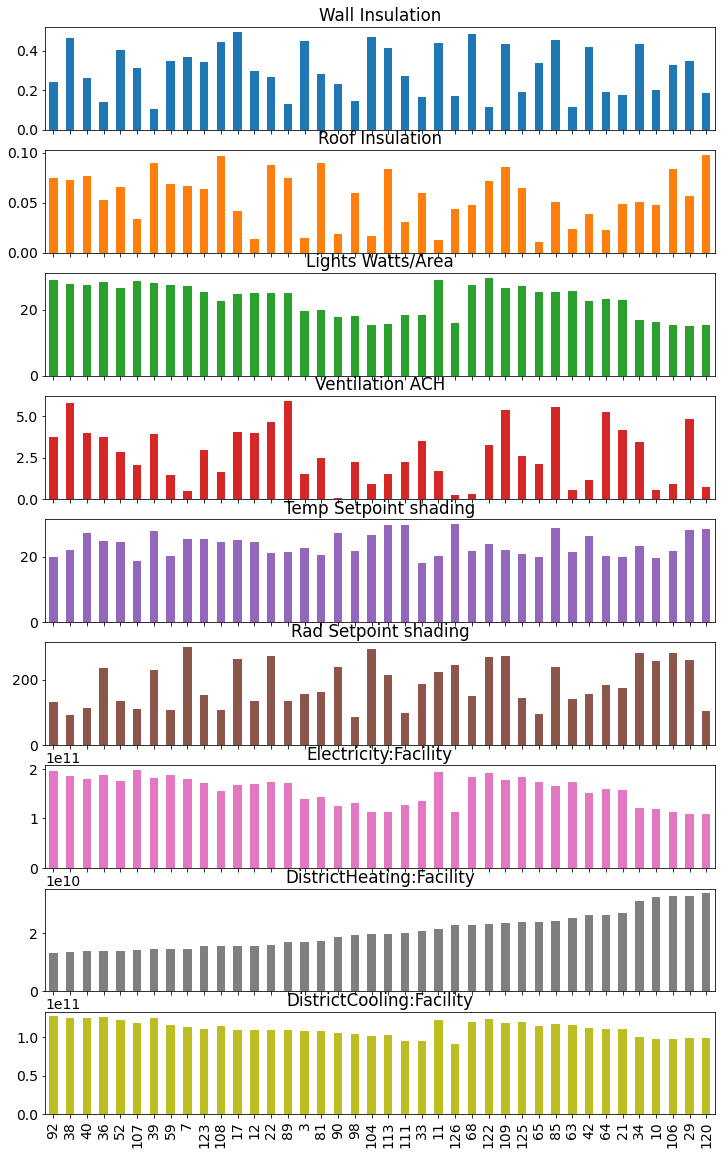

In [80]:
sim_samples = sim_samples.sort_values(by=objectives[1])
ax=sim_samples.plot.bar(subplots=True,legend=None, figsize=(12,20))

## Visualising the parametric analysis

A better way to analyse the results is by looking at scatter plots of the inputs versus the outputs.  
This enables us to visually see strong relationships of inputs and outputs.

In [91]:
samples1 = samples.drop('ShadingWindowType',axis=1)

In [92]:
samples1

Wall Insulation  Roof Insulation  \
7           0.227517         0.017198   
10          0.186016         0.083834   
12          0.403764         0.041921   
14          0.207772         0.015768   
16          0.237008         0.080736   
17          0.435199         0.074425   
19          0.189381         0.080272   
20          0.165602         0.029281   
22          0.185180         0.072640   
25          0.358809         0.033364   
29          0.144474         0.056137   
31          0.454129         0.026604   
34          0.307145         0.042335   
35          0.203232         0.036385   
37          0.433526         0.085976   
38          0.324458         0.035144   
43          0.336654         0.085116   
44          0.309425         0.069130   
56          0.232352         0.067106   
59          0.229155         0.070990   
67          0.338240         0.056416   
74          0.246992         0.067739   
78          0.251777         0.058959   
82          0.374338         0.011536   
83          0.418917         0.012721   
87          0.493655         0.035944   
95          0.366737         0.094377   
97          0.215693         0.018564   
104         0.485332         0.020967   
105         0.119012         0.040571   
107         0.174997         0.064972   
110         0.194913         0.011871   
119         0.341229         0.093975   
120         0.467090         0.095817   
123         0.452043         0.071887   
128         0.331915         0.085449   
133         0.225182         0.010905   
134         0.490311         0.064538   
135         0.254017         0.059690   
136         0.371266         0.024686   

                                  Windows types  Lights Watts/Area  \
7                            Sgl Clr 6mm - 1001          21.381945   
10   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          22.440241   
12      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          26.918016   
14                           Sgl Clr 6mm - 1001          26.687891   
16   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          15.875133   
17                           Sgl Clr 6mm - 1001          17.255989   
19                           Sgl Clr 6mm - 1001          25.269751   
20      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          21.052965   
22   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          21.285036   
25      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          16.938573   
29                           Sgl Clr 6mm - 1001          17.550133   
31   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          23.636901   
34   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          18.650220   
35   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          22.756261   
37                           Sgl Clr 6mm - 1001          23.026141   
38      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          24.704415   
43                           Sgl Clr 6mm - 1001          23.962749   
44      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          24.629810   
56                           Sgl Clr 6mm - 1001          25.800276   
59   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          22.891932   
67                           Sgl Clr 6mm - 1001          24.006839   
74                           Sgl Clr 6mm - 1001          18.871130   
78      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          28.791638   
82      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          15.991138   
83                           Sgl Clr 6mm - 1001          27.144956   
87      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          15.246694   
95   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          29.779528   
97      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          23.583922   
104     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          15.394238   
105     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          15.737743   
107  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          22.253818   
110     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          23.016713   
119  Trp LoE 

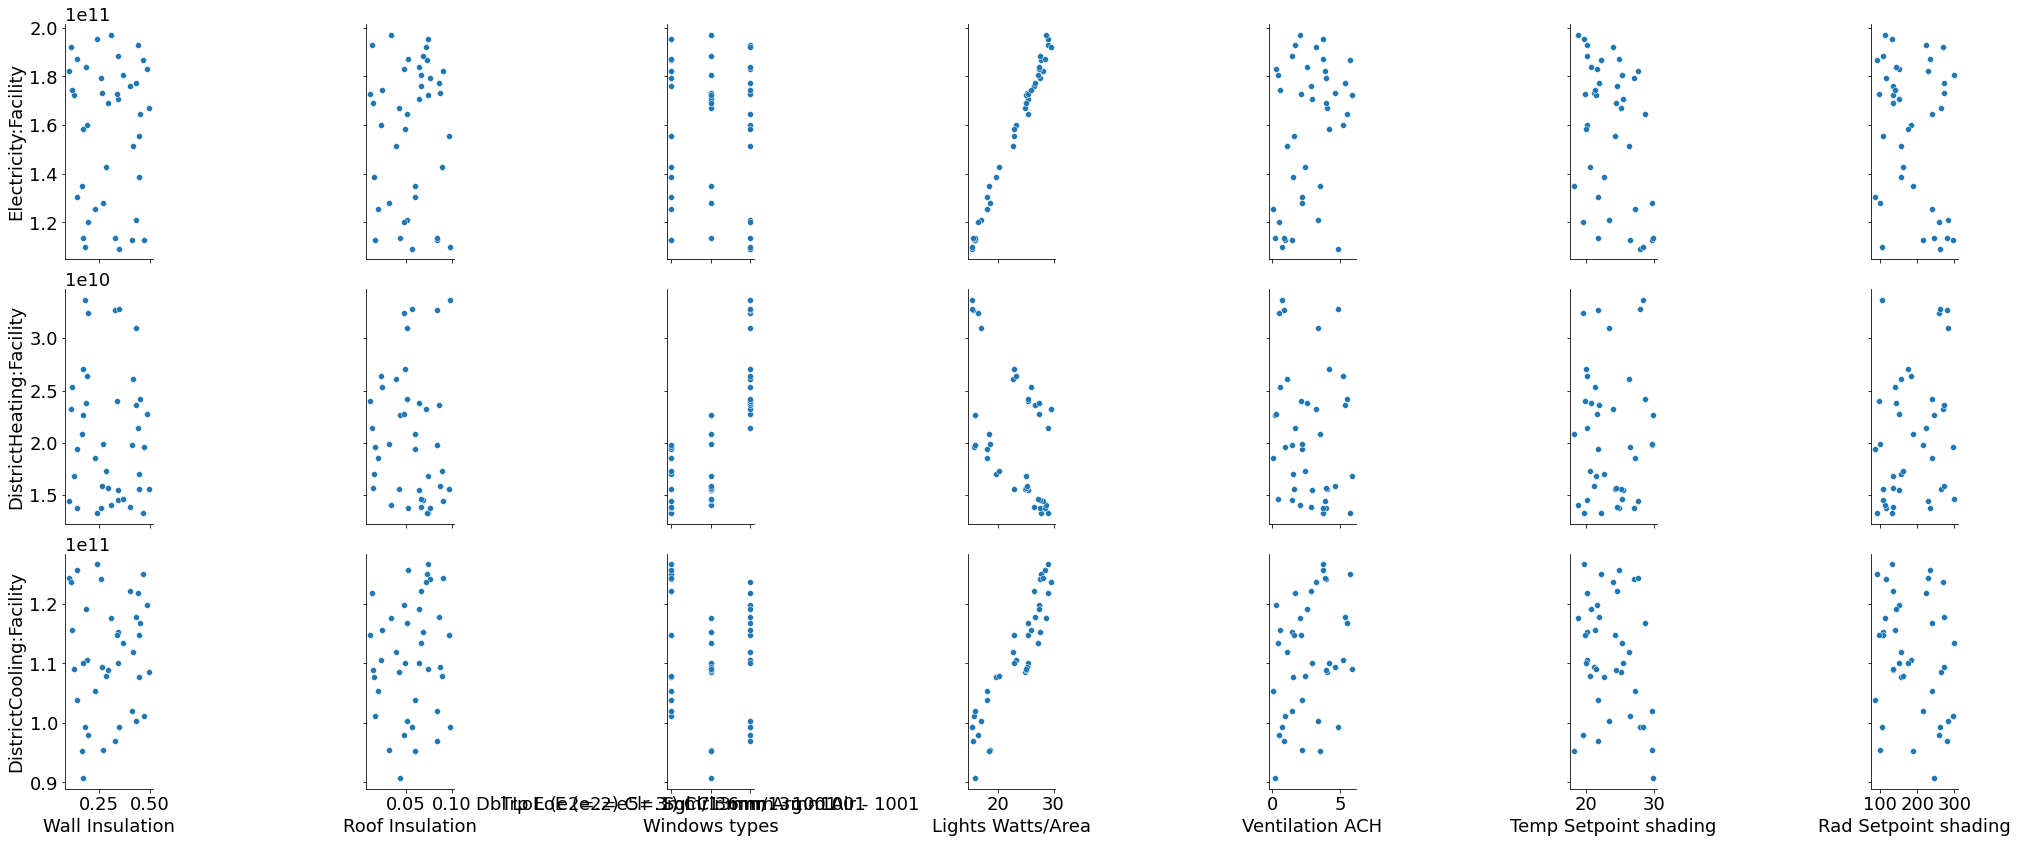

In [95]:
plt.rcParams.update({'font.size': 18})
_=pairplot(sim_samples,x_vars=samples1.columns, y_vars=objectives, kind="scatter",height=4)

### Correlation heat map
Another way to analyse the impact of the inputs on the outputs is by analysing the correlation.  
A common metric is the Pearsson correlation coefficient:

$ r = \frac{N\sum{XY}-(\sum{X}\sum{Y})}{\sqrt{ [N\sum{x^2}-(\sum{x})^2 ][N\sum{y^2}-(\sum{y})^2 }]} $

where N is the number of samples. $X$ is the vector of observation of variable 1 (e.g. wall conductivity) and $Y$ is the vetor of observations of variable 2 (e.g. electricity consumption).  
The closer $r$ is to one the stronger the correlation, and similarly for negative one and negative correleation.

To visualize the correlation coefficients of all inputs and outputs, we can plot a heatmap:

In [96]:
corr=sim_samples.corr()
corr

Wall Insulation  Roof Insulation  Lights Watts/Area  \
Wall Insulation                  1.000000        -0.126753           0.000367   
Roof Insulation                 -0.126753         1.000000           0.046911   
Lights Watts/Area                0.000367         0.046911           1.000000   
Ventilation ACH                 -0.050752         0.222244           0.348426   
Temp Setpoint shading            0.124008         0.081217          -0.320591   
Rad Setpoint shading             0.112457         0.005626          -0.221543   
Electricity:Facility            -0.011577         0.037536           0.994866   
DistrictHeating:Facility        -0.091164        -0.083176          -0.555521   
DistrictCooling:Facility         0.063801         0.123122           0.913947   

                          Ventilation ACH  Temp Setpoint shading  \
Wall Insulation                 -0.050752               0.124008   
Roof Insulation                  0.222244               0.081217   
Lights Watts/Area                0.348426              -0.320591   
Ventilation ACH                  1.000000              -0.113139   
Temp Setpoint shading           -0.113139               1.000000   
Rad Setpoint shading             0.000313               0.203127   
Electricity:Facility             0.343550              -0.402615   
DistrictHeating:Facility        -0.177364               0.008694   
DistrictCooling:Facility         0.316172              -0.235845   

                          Rad Setpoint shading  Electricity:Facility  \
Wall Insulation                       0.112457             -0.011577   
Roof Insulation                       0.005626              0.037536   
Lights Watts/Area                    -0.221543              0.994866   
Ventilation ACH                       0.000313              0.343550   
Temp Setpoint shading                 0.203127             -0.402615   
Rad Setpoint shading                  1.000000             -0.251426   
Electricity:Facility                 -0.251426              1.000000   
DistrictHeating:Facility              0.282978             -0.562868   
DistrictCooling:Facility             -0.231753              0.895859   

                          DistrictHeating:Facility  DistrictCooling:Facility  
Wall Insulation                          -0.091164                  0.063801  
Roof Insulation                          -0.083176                  0.123122  
Lights Watts/Area                        -0.555521                  0.913947  
Ventilation ACH                          -0.177364                  0.316172  
Temp Setpoint shading                     0.008694                 -0.235845  
Rad Setpoint shading                      0.282978                 -0.231753  
Electricity:Facility                     -0.562868                  0.895859  
DistrictHeating:Facility                  1.000000                 -0.501173  
DistrictCooling:Facility                 -0.501173                  1.000000

In [97]:
corr.drop(objectives, axis = 1, inplace = True)
corr.drop(['Roof Insulation','Wall Insulation', 'Lights Watts/Area','Ventilation ACH','Temp Setpoint shading', 'Rad Setpoint shading'], axis = 0 ,inplace = True)
corr

Wall Insulation  Roof Insulation  Lights Watts/Area  \
Electricity:Facility            -0.011577         0.037536           0.994866   
DistrictHeating:Facility        -0.091164        -0.083176          -0.555521   
DistrictCooling:Facility         0.063801         0.123122           0.913947   

                          Ventilation ACH  Temp Setpoint shading  \
Electricity:Facility             0.343550              -0.402615   
DistrictHeating:Facility        -0.177364               0.008694   
DistrictCooling:Facility         0.316172              -0.235845   

                          Rad Setpoint shading  
Electricity:Facility                 -0.251426  
DistrictHeating:Facility              0.282978  
DistrictCooling:Facility             -0.231753

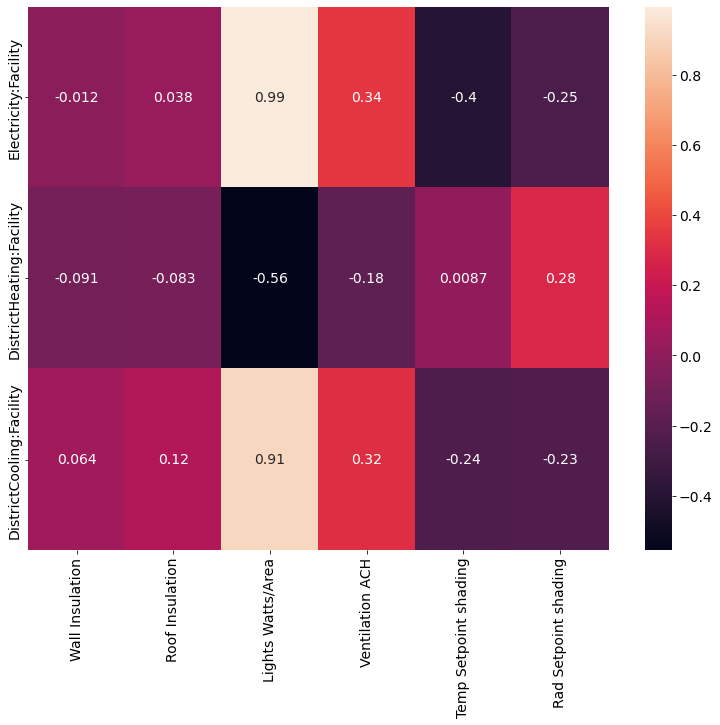

In [98]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)

# Setup the dataset for the Surrogate Model

In [99]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import warnings

In [100]:
features = list(samples.columns)
print(features)
print(objectives)

['Wall Insulation', 'Roof Insulation', 'Windows types', 'Lights Watts/Area', 'Ventilation ACH', 'Temp Setpoint shading', 'Rad Setpoint shading', 'ShadingWindowType']
['Electricity:Facility', 'DistrictHeating:Facility', 'DistrictCooling:Facility']


In [101]:
#remove inputs
outputs = sim_samples.drop(features, axis=1)
outputs

Electricity:Facility  DistrictHeating:Facility  DistrictCooling:Facility
92           1.955356e+11              1.326665e+10              1.266615e+11
38           1.866297e+11              1.333304e+10              1.250865e+11
40           1.792009e+11              1.373688e+10              1.241405e+11
36           1.870063e+11              1.382236e+10              1.256199e+11
52           1.758659e+11              1.390455e+10              1.222379e+11
107          1.970997e+11              1.406673e+10              1.177117e+11
39           1.820606e+11              1.445189e+10              1.242912e+11
59           1.885404e+11              1.458797e+10              1.152280e+11
7            1.805845e+11              1.466113e+10              1.134204e+11
123          1.706101e+11              1.552713e+10              1.100166e+11
108          1.553771e+11              1.555933e+10              1.148097e+11
17           1.668485e+11              1.562252e+10              1.085136e+11
12           1.691860e+11              1.571342e+10              1.088595e+11
22           1.731016e+11              1.586175e+10              1.093918e+11
89           1.721581e+11              1.683378e+10              1.090044e+11
3            1.385067e+11              1.701788e+10              1.076348e+11
81           1.429565e+11              1.734324e+10              1.079579e+11
90           1.256231e+11              1.859591e+10              1.053946e+11
98           1.305923e+11              1.938023e+10              1.038677e+11
104          1.126352e+11              1.961102e+10              1.011421e+11
113          1.126058e+11              1.976529e+10              1.020411e+11
111          1.281101e+11              1.992424e+10              9.547186e+10
33           1.349039e+11              2.082572e+10              9.532609e+10
11           1.930463e+11              2.138365e+10              1.218136e+11
126          1.135549e+11              2.264697e+10              9.073100e+10
68           1.831533e+11              2.279761e+10              1.198032e+11
122          1.921131e+11              2.325629e+10              1.235997e+11
109          1.771234e+11              2.360459e+10              1.178251e+11
125          1.836625e+11              2.385635e+10              1.191194e+11
65           1.729474e+11              2.398096e+10              1.147727e+11
85           1.646604e+11              2.420303e+10              1.168496e+11
63           1.744926e+11              2.533593e+10              1.155935e+11
42           1.515860e+11              2.613547e+10              1.119693e+11
64           1.601233e+11              2.636316e+10              1.106017e+11
21           1.581976e+11              2.705266e+10              1.100888e+11
34           1.208056e+11              3.101493e+10              1.003106e+11
10           1.200391e+11              3.240967e+10              9.796508e+10
106          1.136141e+11              3.275814e+10              9.694894e+10
29           1.092245e+11              3.281533e+10              9.934227e+10
120          1.097667e+11              3.371449e+10              9.935329e+10

In [102]:
#remove outputs and windows types shading
samples = sim_samples.drop(objectives, axis=1)
samples

Wall Insulation  Roof Insulation  \
92          0.238766         0.074188   
38          0.466091         0.072574   
40          0.259061         0.076592   
36          0.140212         0.052292   
52          0.402474         0.065857   
107         0.310927         0.033173   
39          0.102374         0.090185   
59          0.344794         0.068708   
7           0.367122         0.066520   
123         0.343509         0.063817   
108         0.445668         0.097114   
17          0.494684         0.042102   
12          0.295638         0.013481   
22          0.265786         0.087503   
89          0.129118         0.074477   
3           0.447793         0.014438   
81          0.282587         0.089664   
90          0.230011         0.019097   
98          0.142242         0.059294   
104         0.469872         0.016186   
113         0.412854         0.083650   
111         0.271539         0.030775   
33          0.164520         0.059966   
11          0.440123         0.012367   
126         0.169857         0.043846   
68          0.485668         0.047261   
122         0.111784         0.071964   
109         0.433045         0.086094   
125         0.188280         0.064641   
65          0.336589         0.010258   
85          0.452862         0.051147   
63          0.116505         0.023393   
42          0.419452         0.038424   
64          0.190910         0.022597   
21          0.172639         0.048637   
34          0.434208         0.050548   
10          0.198106         0.047733   
106         0.328088         0.084088   
29          0.349275         0.056911   
120         0.183023         0.097753   

                                  Windows types  Lights Watts/Area  \
92      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          28.907138   
38      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          27.802618   
40      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          27.534337   
36      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          28.533269   
52      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          26.455729   
107  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          28.715245   
39      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          28.150393   
59   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          27.517707   
7    Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          27.268434   
123  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          25.463442   
108     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          22.799845   
17   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          24.812759   
12   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          25.037924   
22   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          25.209005   
89   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          24.956933   
3       Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          19.588548   
81      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          20.060681   
90      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          17.917516   
98      Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          18.028273   
104     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          15.518380   
113     Dbl LoE (e2=.2) Clr 3mm/13mm Arg - 1001          15.799387   
111  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          18.471540   
33   Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          18.254419   
11                           Sgl Clr 6mm - 1001          29.013629   
126  Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001          15.844333   
68                           Sgl Clr 6mm - 1001          27.404087   
122                          Sgl Clr 6mm - 1001          29.617230   
109                          Sgl Clr 6mm - 1001          26.596872   
125                          Sgl Clr 6mm - 1001          27.336736   
65                           Sgl Clr 6mm - 1001          25.310355   
85                           Sgl Clr 6mm - 1001          25.400518   
63                           Sgl Clr 6mm - 1001          25.829311   
42           

In [103]:
# samples = samples.drop('ShadingWindowType',axis=1)

In [104]:
for i,win in enumerate(win_arr):
    samples['Windows types'] = samples['Windows types'].replace(win,i+1)

In [105]:
samples

Wall Insulation  Roof Insulation  Windows types  Lights Watts/Area  \
92          0.238766         0.074188              2          28.907138   
38          0.466091         0.072574              2          27.802618   
40          0.259061         0.076592              2          27.534337   
36          0.140212         0.052292              2          28.533269   
52          0.402474         0.065857              2          26.455729   
107         0.310927         0.033173              3          28.715245   
39          0.102374         0.090185              2          28.150393   
59          0.344794         0.068708              3          27.517707   
7           0.367122         0.066520              3          27.268434   
123         0.343509         0.063817              3          25.463442   
108         0.445668         0.097114              2          22.799845   
17          0.494684         0.042102              3          24.812759   
12          0.295638         0.013481              3          25.037924   
22          0.265786         0.087503              3          25.209005   
89          0.129118         0.074477              3          24.956933   
3           0.447793         0.014438              2          19.588548   
81          0.282587         0.089664              2          20.060681   
90          0.230011         0.019097              2          17.917516   
98          0.142242         0.059294              2          18.028273   
104         0.469872         0.016186              2          15.518380   
113         0.412854         0.083650              2          15.799387   
111         0.271539         0.030775              3          18.471540   
33          0.164520         0.059966              3          18.254419   
11          0.440123         0.012367              1          29.013629   
126         0.169857         0.043846              3          15.844333   
68          0.485668         0.047261              1          27.404087   
122         0.111784         0.071964              1          29.617230   
109         0.433045         0.086094              1          26.596872   
125         0.188280         0.064641              1          27.336736   
65          0.336589         0.010258              1          25.310355   
85          0.452862         0.051147              1          25.400518   
63          0.116505         0.023393              1          25.829311   
42          0.419452         0.038424              1          22.655539   
64          0.190910         0.022597              1          23.250529   
21          0.172639         0.048637              1          22.894387   
34          0.434208         0.050548              1          16.824730   
10          0.198106         0.047733              1          16.324998   
106         0.328088         0.084088              1          15.394108   
29          0.349275         0.056911              1          15.180211   
120         0.183023         0.097753              1          15.302158   

     Ventilation ACH  Temp Setpoint shading  Rad Setpoint shading  \
92          3.729700              19.737488            131.297223   
38          5.783565              22.163825             91.184196   
40          3.967493              27.145186            114.385282   
36          3.763326              24.934484            235.150415   
52          2.845787              24.531763            135.506387   
107         2.037663              18.792537            111.490704   
39          3.926204              27.718986            229.623142   
59          1.464885              20.179255            107.003113   
7           0.456537              25.355470            299.536152   
123         2.974499              25.492252            151.669320   
108         1.596564              24.343611            106.391670   
17          4.039786              25.242815            263.250462   
12          3.959356            

In [106]:
for i,win in enumerate(win_arr):
    samples['ShadingWindowType'] = samples['Windows types']

In [107]:
# for i,win in enumerate(win_arr):
#     samples['Windows types'] = samples['Windows types'].replace(win,i+1)

In [108]:
samples

Wall Insulation  Roof Insulation  Windows types  Lights Watts/Area  \
92          0.238766         0.074188              2          28.907138   
38          0.466091         0.072574              2          27.802618   
40          0.259061         0.076592              2          27.534337   
36          0.140212         0.052292              2          28.533269   
52          0.402474         0.065857              2          26.455729   
107         0.310927         0.033173              3          28.715245   
39          0.102374         0.090185              2          28.150393   
59          0.344794         0.068708              3          27.517707   
7           0.367122         0.066520              3          27.268434   
123         0.343509         0.063817              3          25.463442   
108         0.445668         0.097114              2          22.799845   
17          0.494684         0.042102              3          24.812759   
12          0.295638         0.013481              3          25.037924   
22          0.265786         0.087503              3          25.209005   
89          0.129118         0.074477              3          24.956933   
3           0.447793         0.014438              2          19.588548   
81          0.282587         0.089664              2          20.060681   
90          0.230011         0.019097              2          17.917516   
98          0.142242         0.059294              2          18.028273   
104         0.469872         0.016186              2          15.518380   
113         0.412854         0.083650              2          15.799387   
111         0.271539         0.030775              3          18.471540   
33          0.164520         0.059966              3          18.254419   
11          0.440123         0.012367              1          29.013629   
126         0.169857         0.043846              3          15.844333   
68          0.485668         0.047261              1          27.404087   
122         0.111784         0.071964              1          29.617230   
109         0.433045         0.086094              1          26.596872   
125         0.188280         0.064641              1          27.336736   
65          0.336589         0.010258              1          25.310355   
85          0.452862         0.051147              1          25.400518   
63          0.116505         0.023393              1          25.829311   
42          0.419452         0.038424              1          22.655539   
64          0.190910         0.022597              1          23.250529   
21          0.172639         0.048637              1          22.894387   
34          0.434208         0.050548              1          16.824730   
10          0.198106         0.047733              1          16.324998   
106         0.328088         0.084088              1          15.394108   
29          0.349275         0.056911              1          15.180211   
120         0.183023         0.097753              1          15.302158   

     Ventilation ACH  Temp Setpoint shading  Rad Setpoint shading  \
92          3.729700              19.737488            131.297223   
38          5.783565              22.163825             91.184196   
40          3.967493              27.145186            114.385282   
36          3.763326              24.934484            235.150415   
52          2.845787              24.531763            135.506387   
107         2.037663              18.792537            111.490704   
39          3.926204              27.718986            229.623142   
59          1.464885              20.179255            107.003113   
7           0.456537              25.355470            299.536152   
123         2.974499              25.492252            151.669320   
108         1.596564              24.343611            106.391670   
17          4.039786              25.242815            263.250462   
12          3.959356            

In [109]:
# outputs = outputs.drop('ShadingWindowType',axis=1)
outputs

Electricity:Facility  DistrictHeating:Facility  DistrictCooling:Facility
92           1.955356e+11              1.326665e+10              1.266615e+11
38           1.866297e+11              1.333304e+10              1.250865e+11
40           1.792009e+11              1.373688e+10              1.241405e+11
36           1.870063e+11              1.382236e+10              1.256199e+11
52           1.758659e+11              1.390455e+10              1.222379e+11
107          1.970997e+11              1.406673e+10              1.177117e+11
39           1.820606e+11              1.445189e+10              1.242912e+11
59           1.885404e+11              1.458797e+10              1.152280e+11
7            1.805845e+11              1.466113e+10              1.134204e+11
123          1.706101e+11              1.552713e+10              1.100166e+11
108          1.553771e+11              1.555933e+10              1.148097e+11
17           1.668485e+11              1.562252e+10              1.085136e+11
12           1.691860e+11              1.571342e+10              1.088595e+11
22           1.731016e+11              1.586175e+10              1.093918e+11
89           1.721581e+11              1.683378e+10              1.090044e+11
3            1.385067e+11              1.701788e+10              1.076348e+11
81           1.429565e+11              1.734324e+10              1.079579e+11
90           1.256231e+11              1.859591e+10              1.053946e+11
98           1.305923e+11              1.938023e+10              1.038677e+11
104          1.126352e+11              1.961102e+10              1.011421e+11
113          1.126058e+11              1.976529e+10              1.020411e+11
111          1.281101e+11              1.992424e+10              9.547186e+10
33           1.349039e+11              2.082572e+10              9.532609e+10
11           1.930463e+11              2.138365e+10              1.218136e+11
126          1.135549e+11              2.264697e+10              9.073100e+10
68           1.831533e+11              2.279761e+10              1.198032e+11
122          1.921131e+11              2.325629e+10              1.235997e+11
109          1.771234e+11              2.360459e+10              1.178251e+11
125          1.836625e+11              2.385635e+10              1.191194e+11
65           1.729474e+11              2.398096e+10              1.147727e+11
85           1.646604e+11              2.420303e+10              1.168496e+11
63           1.744926e+11              2.533593e+10              1.155935e+11
42           1.515860e+11              2.613547e+10              1.119693e+11
64           1.601233e+11              2.636316e+10              1.106017e+11
21           1.581976e+11              2.705266e+10              1.100888e+11
34           1.208056e+11              3.101493e+10              1.003106e+11
10           1.200391e+11              3.240967e+10              9.796508e+10
106          1.136141e+11              3.275814e+10              9.694894e+10
29           1.092245e+11              3.281533e+10              9.934227e+10
120          1.097667e+11              3.371449e+10              9.935329e+10

## Train-test split

Next we split the data into a training set (80%) and a testing set (20%).

In [110]:
train_in, test_in, train_out, test_out = train_test_split(
    samples, outputs, test_size=0.2
)

## Normalization of inputs

To ensure an equal weighting of inputs and outputs in the backpropagation algorithm fitting the neural network, we have to normalize the input values.
For example window-to-wall ratio is in the range of 0 to 1 while the $W/$m^2$ are in a range of 10 to 15.
Different options for normalization exist.
Here we bring all features (input variables) to have zero mean and a standarddeviation of 1.
Note that we fit the normalizer on training data only.

In [111]:
scaler = StandardScaler()
train_in_scale = scaler.fit_transform(X=train_in)
test_in_scale = scaler.fit_transform(X=test_in)

scaler_out = StandardScaler()
train_out_scale = scaler_out.fit_transform(X=train_out)
test_out_scale = scaler_out.fit_transform(X=test_out)

# Gaussian Process


## Hyper-parameters

Before fitting the GP model we define the set of hyperparameters we want to optimize.
Here we use \textit{3} folds in the k-fold cross validation scheme.
We select a set of Kernel functions, which must fit the characteristics of a problem - details and examples may be found in the [Kernel cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/).
Note that the parameters of the Kernel itself are [optimized during each model fitting run](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html).

In [112]:
hyperparameters = {
    "kernel": [
        None,
        1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
        1.0 * RationalQuadratic(length_scale=1.0, alpha=0.5),
        # ConstantKernel(0.1, (0.01, 10.0))*(DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0))**2),
        1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
    ]
}

folds = 3

## Model fitting

Here we fit the model using these hyperparameters.

In [113]:
gp = GaussianProcessRegressor(normalize_y=True)

clf = GridSearchCV(gp, hyperparameters, cv=folds)

clf.fit(train_in_scale, train_out_scale)

best_gp = clf.best_estimator_ 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [114]:
prediction_gp = scaler_out.inverse_transform(best_gp.predict(test_in_scale))

# Neural Network

## Hyper-parameters

Before we start fitting the NN model we define the set of hyperparameters we want to analyse in our cross-validation to optimize the model.
Here, we select the number of layers of the network as well as the regularization parameter alpha as parameter value.
A larger number of layers and a lower value of the regularizer lead to higher variance of the network.
This may lead to overfitting.
The best selection may be found using an optimizer like Bayesian Optimization.
In this example we use a simple grid search.

In [115]:
hyperparameters = {
    "hidden_layer_sizes": (
        (len(parameters) * 16,),
        (len(parameters) * 16, len(parameters) * 16),
    ),
    "alpha": [1, 10, 10 ** 3],
}

neural_net = MLPRegressor(max_iter=1000, early_stopping=False)
folds = 3

## Model fitting

Here, we use the NN model from ScikitLearn.


In [116]:
clf = GridSearchCV(neural_net, hyperparameters, cv=folds)
clf.fit(train_in_scale, train_out_scale)

nn_model = clf.best_estimator_

In [117]:
prediction_nn = scaler_out.inverse_transform(nn_model.predict(test_in_scale))

In [118]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [119]:
def build_model():
    model = keras.Sequential(
        [
            layers.Input(shape=(train_in_scale.shape[1], )),
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(3),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])
    return model

tf_model = build_model()

tf_model.summary()

EPOCHS = 1000

history = tf_model.fit(
    train_in_scale,
    train_out_scale,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
)

2023-03-27 15:14:19.973921: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1152      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 21,891
Trainable params: 21,891
Non-trainable params: 0
_________________________________________________________________


In [120]:
prediction_tf = scaler_out.inverse_transform(tf_model.predict(test_in_scale))

In [121]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt


In [122]:
mean_squared_error(prediction_gp,test_out.values,multioutput='raw_values',squared=False)/test_out.mean()*100

Electricity:Facility         0.988799
DistrictHeating:Facility    11.361214
DistrictCooling:Facility     2.926168
dtype: float64

In [123]:
mean_squared_error(prediction_nn,test_out.values,multioutput='raw_values',squared=False)/test_out.mean()*100

Electricity:Facility        0.838868
DistrictHeating:Facility    7.918599
DistrictCooling:Facility    2.278742
dtype: float64

In [124]:
mean_squared_error(prediction_tf,test_out.values,multioutput='raw_values',squared=False)/test_out.mean()*100

Electricity:Facility         4.327356
DistrictHeating:Facility    14.151319
DistrictCooling:Facility     3.194649
dtype: float64

Try with more samples 20 and 40

In [80]:
#You can load the data from the files in the sim_samples_folder
# 20 samples generation took: 5 min 18 seconds
# 40 samples generation took: 19 min  7 seconds


## Surrogate Modelling Evaluator object
We can wrap the fitted model in a BESOS `Evaluator`.

In [125]:
#Selection of windows parameters
win_arr=[1,2,3]
windowsTypes = CategoryParameter(win_arr)
windowsTypes

CategoryParameter(options=[1, 2, 3])

In [126]:
shadingwindow_arr = [1,2,3]
shadingwindowTypes = CategoryParameter(shadingwindow_arr)
shadingwindowTypes

CategoryParameter(options=[1, 2, 3])

In [127]:
windowsParameters = []
shadingwindowsParameters = []

for fenestration in building.idfobjects["FenestrationSurface:Detailed"]:
     if fenestration.obj[2] == "Window": 
        sel = FieldSelector(class_name ='FenestrationSurface:Detailed', object_name = fenestration.Name, \
                            field_name='Construction Name' )
        windowsParameters.append(Parameter(selector=sel, value_descriptors = windowsTypes, name='Windows types'))
        
        

/home/ict4bd/ict4bd/lib/python3.8/site-packages/besos/parameters.py:441: UserWarning: This parameter's descriptor is already named Windows types.The name used as an input (Windows types) will be discarded.
  warnings.warn(


In [128]:
for shadingtype in building.idfobjects['WINDOWSHADINGCONTROL']:
    sel_shading = FieldSelector(class_name='WINDOWSHADINGCONTROL', object_name = shadingtype.Name,\
                                field_name='Construction with Shading Name')
    shadingwindowsParameters.append(Parameter(selector=sel_shading, value_descriptors=shadingwindowTypes,\
                                             name = 'ShadingWindowType'))

/home/ict4bd/ict4bd/lib/python3.8/site-packages/besos/parameters.py:441: UserWarning: This parameter's descriptor is already named ShadingWindowType.The name used as an input (ShadingWindowType) will be discarded.
  warnings.warn(


In [129]:
parameters = insulation_param + windowsParameters + [lights_param]  + ventilationAchParam + setpointParams \
                + shadingwindowsParameters

In [130]:
parameters

[Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_.35'), value_descriptors=[RangeParameter(min=0.1, max=0.5)]),
 Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='MW Glass Wool (high performance panels)_.02'), value_descriptors=[RangeParameter(min=0.01, max=0.1)]),
 Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='F01:Toileta_Wall_7_0_0_0_0_0_Win'), value_descriptors=[CategoryParameter(options=[1, 2, 3])]),
 Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='F01:Toileta_Wall_8_0_0_0_0_1_Win'), value_descriptors=[CategoryParameter(options=[1, 2, 3])]),
 Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='F01:Toileta_Wall_8_0_0_1_0_0_Win'), value_descripto

In [131]:
#objectives and problem definition
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility']

problem=Problem(parameters, objectives)


In [132]:
objectives

['Electricity:Facility',
 'DistrictHeating:Facility',
 'DistrictCooling:Facility']

In [133]:
problem

Problem(inputs=[Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_.35'), value_descriptors=[RangeParameter(min=0.1, max=0.5)]), Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='MW Glass Wool (high performance panels)_.02'), value_descriptors=[RangeParameter(min=0.01, max=0.1)]), Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='F01:Toileta_Wall_7_0_0_0_0_0_Win'), value_descriptors=[CategoryParameter(options=[1, 2, 3])]), Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='F01:Toileta_Wall_8_0_0_0_0_1_Win'), value_descriptors=[CategoryParameter(options=[1, 2, 3])]), Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='F01:Toileta_Wall_8_0_0_1_0_0_Win'), valu

In [134]:
#definition of the evaluation function
def evaluation_func(ind, scaler=scaler):
    ind = scaler.transform(X=[ind])
    return (scaler_out.inverse_transform(nn_model.predict(ind))[0]).tolist()

evaluator = EvaluatorGeneric(evaluation_func, problem)


In [135]:
srinputs = sampling.dist_sampler(sampling.lhs, problem, 5000)
for i,win in enumerate(win_arr):
    srinputs['Windows types'] = srinputs['Windows types'].replace(win,i+1)
srinputs

Wall Insulation  Roof Insulation  Windows types  Lights Watts/Area  \
0            0.396736         0.087828              2          16.116864   
1            0.246761         0.054416              1          29.548883   
2            0.485286         0.036848              1          20.905886   
3            0.282889         0.025036              1          21.504537   
4            0.180715         0.081937              3          19.127127   
...               ...              ...            ...                ...   
4995         0.378510         0.057235              3          20.234019   
4996         0.423667         0.065068              3          27.357915   
4997         0.478863         0.072304              3          28.165311   
4998         0.337363         0.015324              1          18.655978   
4999         0.441946         0.021173              1          15.922276   

      Ventilation ACH  Temp Setpoint shading  Rad Setpoint shading  \
0            2.717518              21.421397            298.949763   
1            2.859055              26.545727             85.138883   
2            0.033534              20.312531            134.869329   
3            0.984390              21.986736            129.882315   
4            3.563457              23.463856            173.201678   
...               ...                    ...                   ...   
4995         0.250699              20.741509            113.053323   
4996         1.691345              21.393681            104.640137   
4997         1.182276              23.887224            210.007776   
4998         0.174933              20.156220            127.333292   
4999         4.280716              29.071638            282.205057   

      ShadingWindowType  
0                     3  
1                     2  
2                     3  
3                     3  
4                     3  
...                 ...  
4995                  1  
4996                  2  
4997                  3  
4998                  3  
4999                  1  

[5000 rows x 8 columns]

In [136]:
srinputs = srinputs[srinputs['Windows types']==srinputs['ShadingWindowType']]
srinputs

Wall Insulation  Roof Insulation  Windows types  Lights Watts/Area  \
4            0.180715         0.081937              3          19.127127   
12           0.499852         0.051514              2          26.747484   
21           0.494113         0.021775              1          23.866707   
24           0.321849         0.047417              1          21.906878   
25           0.132525         0.079058              1          20.941459   
...               ...              ...            ...                ...   
4991         0.407605         0.035271              3          20.620900   
4992         0.405300         0.015245              3          18.226406   
4994         0.248842         0.069333              2          21.880915   
4997         0.478863         0.072304              3          28.165311   
4999         0.441946         0.021173              1          15.922276   

      Ventilation ACH  Temp Setpoint shading  Rad Setpoint shading  \
4            3.563457              23.463856            173.201678   
12           4.062415              29.745732            255.316328   
21           1.857159              24.160349            245.169761   
24           0.481242              25.128712            149.244947   
25           4.854576              29.311608            281.653935   
...               ...                    ...                   ...   
4991         5.975189              24.297460            273.218649   
4992         2.132627              25.884266            182.239324   
4994         4.135981              22.397777            231.548180   
4997         1.182276              23.887224            210.007776   
4999         4.280716              29.071638            282.205057   

      ShadingWindowType  
4                     3  
12                    2  
21                    1  
24                    1  
25                    1  
...                 ...  
4991                  3  
4992                  3  
4994                  2  
4997                  3  
4999                  1  

[1680 rows x 8 columns]

In [137]:
sroutputs = evaluator.df_apply(srinputs)
srresults = srinputs.join(sroutputs)
srresults.head()

Executing:   0%|          | 0/1680 [00:00<?, ?row/s]

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWa

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWa

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWa

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWa

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWa

Wall Insulation  Roof Insulation  Windows types  Lights Watts/Area  \
4          0.180715         0.081937              3          19.127127   
12         0.499852         0.051514              2          26.747484   
21         0.494113         0.021775              1          23.866707   
24         0.321849         0.047417              1          21.906878   
25         0.132525         0.079058              1          20.941459   

    Ventilation ACH  Temp Setpoint shading  Rad Setpoint shading  \
4          3.563457              23.463856            173.201678   
12         4.062415              29.745732            255.316328   
21         1.857159              24.160349            245.169761   
24         0.481242              25.128712            149.244947   
25         4.854576              29.311608            281.653935   

    ShadingWindowType  Electricity:Facility  DistrictHeating:Facility  \
4                   3          1.358532e+11              2.278983e+10   
12                  2          1.737441e+11              1.698193e+10   
21                  1          1.603040e+11              2.470265e+10   
24                  1          1.499144e+11              2.603226e+10   
25                  1          1.393722e+11              2.972124e+10   

    DistrictCooling:Facility  
4               9.361457e+10  
12              1.196882e+11  
21              1.141478e+11  
24              1.105512e+11  
25              1.083404e+11

## Exploration

In [138]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [139]:
features = features[:]
features

['Wall Insulation',
 'Roof Insulation',
 'Windows types',
 'Lights Watts/Area',
 'Ventilation ACH',
 'Temp Setpoint shading',
 'Rad Setpoint shading',
 'ShadingWindowType']

In [140]:
import plotly.express as px
fig = px.parallel_coordinates(srresults,color="Electricity:Facility", dimensions=features+objectives,
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

In [141]:
fig = px.parallel_coordinates(srresults,color="DistrictHeating:Facility", dimensions=features+objectives,
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

In [142]:
fig = px.parallel_coordinates(srresults,color="DistrictCooling:Facility", dimensions=features+objectives,
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

# Perform Building Optimization 

Using the best surrogate perfomr an otimization process, selct optimal values and save a new idf with the selected values. Evalute the goodnes of the surrogate simuation with EnergyPlus.

In [145]:
from besos.optimizer import NSGAII

In [170]:
#running NSGA-II optimizator 
results = NSGAII(evaluator, evaluations=5000, population_size=10000)



/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/ict4bd/ict4bd/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted 

In [171]:
optres = results.loc[results["pareto-optimal"] == True, :]  # Get only the optimal results

Text(0.5, 0, 'Electricity demand')

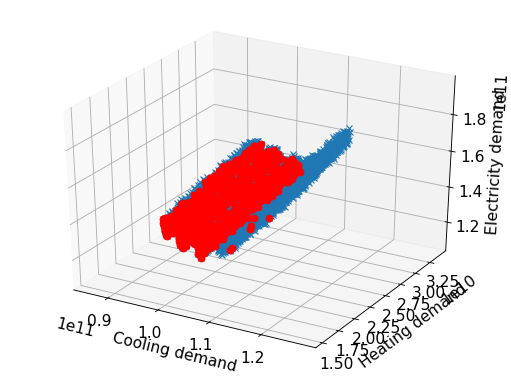

In [172]:
#plotting results
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')



df = pd.DataFrame(optres, columns=features + objectives)

ax.plot3D(results["DistrictCooling:Facility"], results["DistrictHeating:Facility"], results["Electricity:Facility"], "x")  # Plot all results in the background as blue crosses
ax.plot3D(optres["DistrictCooling:Facility"], optres["DistrictHeating:Facility"], optres["Electricity:Facility"], "ro")  # Plot optimal results in red

ax.set_xlabel("Cooling demand")
ax.set_ylabel("Heating demand")
ax.set_zlabel("Electricity demand")



In [173]:
optres

Wall Insulation  Roof Insulation  Windows types  Lights Watts/Area  \
6            0.496742         0.052825              1          24.156416   
11           0.372454         0.071988              3          26.109020   
44           0.410112         0.093444              2          26.193389   
53           0.373187         0.084564              3          27.714118   
64           0.294535         0.036511              3          22.414286   
...               ...              ...            ...                ...   
9906         0.462603         0.033120              3          21.316931   
9912         0.392258         0.054704              2          15.356015   
9915         0.343762         0.040913              3          21.490868   
9936         0.492592         0.087139              1          27.793197   
9980         0.388202         0.091606              3          27.673408   

      Ventilation ACH  Temp Setpoint shading  Rad Setpoint shading  \
6            0.323143              21.422853            229.476082   
11           0.238541              25.225329            231.005237   
44           0.126833              25.275561             89.852710   
53           0.429787              19.453993            139.253168   
64           1.881734              18.323881             91.836171   
...               ...                    ...                   ...   
9906         2.599867              20.996958            197.838840   
9912         1.302300              28.984549            193.738091   
9915         0.506575              19.682328            129.382127   
9936         1.572019              24.508084            133.659971   
9980         0.898369              25.131024            166.690892   

      ShadingWindowType  Electricity:Facility  DistrictHeating:Facility  \
6                     3          1.657665e+11              1.771495e+10   
11                    3          1.735581e+11              1.829406e+10   
44                    3          1.772628e+11              1.720272e+10   
53                    3          1.887699e+11              1.710711e+10   
64                    3          1.598313e+11              2.023406e+10   
...                 ...                   ...                       ...   
9906                  1          1.501782e+11              1.946600e+10   
9912                  3          1.099101e+11              2.400758e+10   
9915                  3          1.527984e+11              2.067973e+10   
9936                  3          1.861062e+11              1.586603e+10   
9980                  2          1.844211e+11              1.661129e+10   

      DistrictCooling:Facility  violation  pareto-optimal  
6                 1.144906e+11          0            True  
11                1.089012e+11          0            True  
44                1.144491e+11          0            True  
53                1.130312e+11          0            True  
64                1.012306e+11          0            True  
...                        ...        ...             ...  
9906              1.084852e+11          0            True  
9912              9.123280e+10          0            True  
9915              9.950117e+10          0            True  
9936              1.222794e+11          0            True  
9980              1.171842e+11          0            True  

[987 rows x 13 columns]

In [174]:
optres.dtypes

Wall Insulation             float64
Roof Insulation             float64
Windows types                 int64
Lights Watts/Area           float64
Ventilation ACH             float64
Temp Setpoint shading       float64
Rad Setpoint shading        float64
ShadingWindowType             int64
Electricity:Facility        float64
DistrictHeating:Facility    float64
DistrictCooling:Facility    float64
violation                     int64
pareto-optimal                 bool
dtype: object

In [175]:
# optres = optres.drop(optres.columns[7],axis=1)
# optres

In [176]:
samples

Wall Insulation  Roof Insulation  Windows types  Lights Watts/Area  \
92          0.238766         0.074188              2          28.907138   
38          0.466091         0.072574              2          27.802618   
40          0.259061         0.076592              2          27.534337   
36          0.140212         0.052292              2          28.533269   
52          0.402474         0.065857              2          26.455729   
107         0.310927         0.033173              3          28.715245   
39          0.102374         0.090185              2          28.150393   
59          0.344794         0.068708              3          27.517707   
7           0.367122         0.066520              3          27.268434   
123         0.343509         0.063817              3          25.463442   
108         0.445668         0.097114              2          22.799845   
17          0.494684         0.042102              3          24.812759   
12          0.295638         0.013481              3          25.037924   
22          0.265786         0.087503              3          25.209005   
89          0.129118         0.074477              3          24.956933   
3           0.447793         0.014438              2          19.588548   
81          0.282587         0.089664              2          20.060681   
90          0.230011         0.019097              2          17.917516   
98          0.142242         0.059294              2          18.028273   
104         0.469872         0.016186              2          15.518380   
113         0.412854         0.083650              2          15.799387   
111         0.271539         0.030775              3          18.471540   
33          0.164520         0.059966              3          18.254419   
11          0.440123         0.012367              1          29.013629   
126         0.169857         0.043846              3          15.844333   
68          0.485668         0.047261              1          27.404087   
122         0.111784         0.071964              1          29.617230   
109         0.433045         0.086094              1          26.596872   
125         0.188280         0.064641              1          27.336736   
65          0.336589         0.010258              1          25.310355   
85          0.452862         0.051147              1          25.400518   
63          0.116505         0.023393              1          25.829311   
42          0.419452         0.038424              1          22.655539   
64          0.190910         0.022597              1          23.250529   
21          0.172639         0.048637              1          22.894387   
34          0.434208         0.050548              1          16.824730   
10          0.198106         0.047733              1          16.324998   
106         0.328088         0.084088              1          15.394108   
29          0.349275         0.056911              1          15.180211   
120         0.183023         0.097753              1          15.302158   

     Ventilation ACH  Temp Setpoint shading  Rad Setpoint shading  \
92          3.729700              19.737488            131.297223   
38          5.783565              22.163825             91.184196   
40          3.967493              27.145186            114.385282   
36          3.763326              24.934484            235.150415   
52          2.845787              24.531763            135.506387   
107         2.037663              18.792537            111.490704   
39          3.926204              27.718986            229.623142   
59          1.464885              20.179255            107.003113   
7           0.456537              25.355470            299.536152   
123         2.974499              25.492252            151.669320   
108         1.596564              24.343611            106.391670   
17          4.039786              25.242815            263.250462   
12          3.959356            

In [177]:
samples11 = samples.drop('ShadingWindowType',axis=1)
samples11

Wall Insulation  Roof Insulation  Windows types  Lights Watts/Area  \
92          0.238766         0.074188              2          28.907138   
38          0.466091         0.072574              2          27.802618   
40          0.259061         0.076592              2          27.534337   
36          0.140212         0.052292              2          28.533269   
52          0.402474         0.065857              2          26.455729   
107         0.310927         0.033173              3          28.715245   
39          0.102374         0.090185              2          28.150393   
59          0.344794         0.068708              3          27.517707   
7           0.367122         0.066520              3          27.268434   
123         0.343509         0.063817              3          25.463442   
108         0.445668         0.097114              2          22.799845   
17          0.494684         0.042102              3          24.812759   
12          0.295638         0.013481              3          25.037924   
22          0.265786         0.087503              3          25.209005   
89          0.129118         0.074477              3          24.956933   
3           0.447793         0.014438              2          19.588548   
81          0.282587         0.089664              2          20.060681   
90          0.230011         0.019097              2          17.917516   
98          0.142242         0.059294              2          18.028273   
104         0.469872         0.016186              2          15.518380   
113         0.412854         0.083650              2          15.799387   
111         0.271539         0.030775              3          18.471540   
33          0.164520         0.059966              3          18.254419   
11          0.440123         0.012367              1          29.013629   
126         0.169857         0.043846              3          15.844333   
68          0.485668         0.047261              1          27.404087   
122         0.111784         0.071964              1          29.617230   
109         0.433045         0.086094              1          26.596872   
125         0.188280         0.064641              1          27.336736   
65          0.336589         0.010258              1          25.310355   
85          0.452862         0.051147              1          25.400518   
63          0.116505         0.023393              1          25.829311   
42          0.419452         0.038424              1          22.655539   
64          0.190910         0.022597              1          23.250529   
21          0.172639         0.048637              1          22.894387   
34          0.434208         0.050548              1          16.824730   
10          0.198106         0.047733              1          16.324998   
106         0.328088         0.084088              1          15.394108   
29          0.349275         0.056911              1          15.180211   
120         0.183023         0.097753              1          15.302158   

     Ventilation ACH  Temp Setpoint shading  Rad Setpoint shading  
92          3.729700              19.737488            131.297223  
38          5.783565              22.163825             91.184196  
40          3.967493              27.145186            114.385282  
36          3.763326              24.934484            235.150415  
52          2.845787              24.531763            135.506387  
107         2.037663              18.792537            111.490704  
39          3.926204              27.718986            229.623142  
59          1.464885              20.179255            107.003113  
7           0.456537              25.355470            299.536152  
123         2.974499              25.492252            151.669320  
108         1.596564              24.343611            106.391670  
17          4.039786              25.242815            263.250462  
12          3.959356              24.391288  

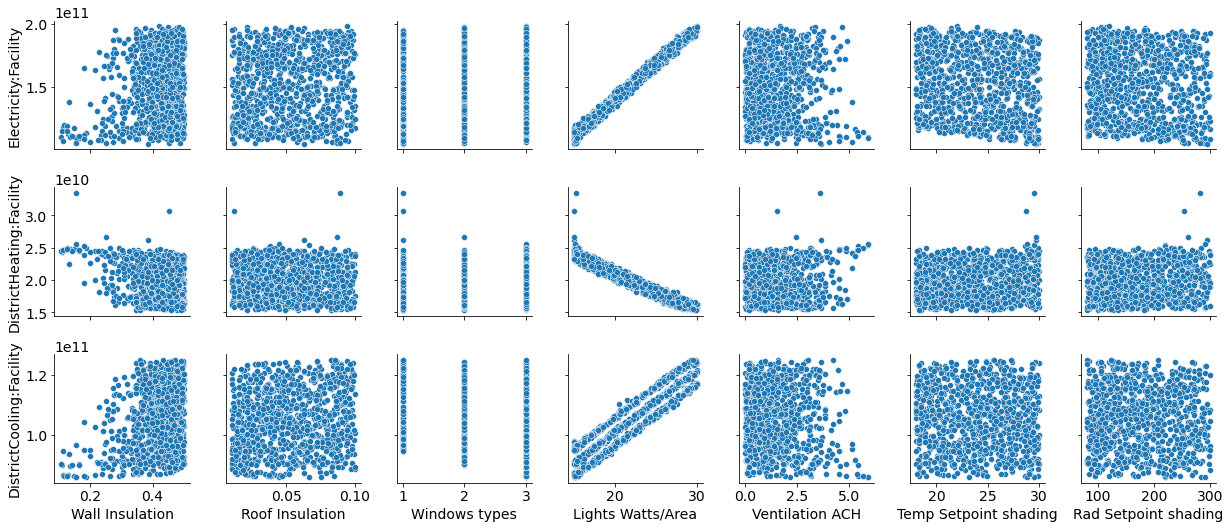

In [178]:
_=pairplot(optres,x_vars=samples11.columns, y_vars=objectives, kind="scatter")

In [179]:
corr=optres.corr()
corr

Wall Insulation  Roof Insulation  Windows types  \
Wall Insulation                  1.000000         0.076420      -0.123550   
Roof Insulation                  0.076420         1.000000       0.033983   
Windows types                   -0.123550         0.033983       1.000000   
Lights Watts/Area                0.232980         0.121724      -0.027814   
Ventilation ACH                  0.102485        -0.116093       0.009109   
Temp Setpoint shading            0.042687         0.104217      -0.037624   
Rad Setpoint shading             0.038796        -0.003346       0.005407   
ShadingWindowType               -0.137028        -0.013757      -0.307060   
Electricity:Facility             0.224489         0.117465      -0.020052   
DistrictHeating:Facility        -0.327046        -0.121911       0.120769   
DistrictCooling:Facility         0.329136         0.140548      -0.239124   
violation                             NaN              NaN            NaN   
pareto-optimal                        NaN              NaN            NaN   

                          Lights Watts/Area  Ventilation ACH  \
Wall Insulation                    0.232980         0.102485   
Roof Insulation                    0.121724        -0.116093   
Windows types                     -0.027814         0.009109   
Lights Watts/Area                  1.000000        -0.052065   
Ventilation ACH                   -0.052065         1.000000   
Temp Setpoint shading             -0.061410         0.065031   
Rad Setpoint shading              -0.031087        -0.069664   
ShadingWindowType                  0.037635         0.052210   
Electricity:Facility               0.992849        -0.049927   
DistrictHeating:Facility          -0.964506         0.094354   
DistrictCooling:Facility           0.927623        -0.067403   
violation                               NaN              NaN   
pareto-optimal                          NaN              NaN   

                          Temp Setpoint shading  Rad Setpoint shading  \
Wall Insulation                        0.042687              0.038796   
Roof Insulation                        0.104217             -0.003346   
Windows types                         -0.037624              0.005407   
Lights Watts/Area                     -0.061410             -0.031087   
Ventilation ACH                        0.065031             -0.069664   
Temp Setpoint shading                  1.000000              0.118507   
Rad Setpoint shading                   0.118507              1.000000   
ShadingWindowType                      0.002897             -0.014398   
Electricity:Facility                  -0.167972             -0.086055   
DistrictHeating:Facility               0.122550              0.081046   
DistrictCooling:Facility              -0.057732             -0.040078   
violation                                   NaN                   NaN   
pareto-optimal                              NaN                   NaN   

                          ShadingWindowType  Electricity:Facility  \
Wall Insulation                   -0.137028              0.224489   
Roof Insulation                   -0.013757              0.117465   
Windows types                     -0.307060             -0.020052   
Lights Watts/Area                  0.037635              0.992849   
Ventilation ACH                    0.052210             -0.049927   
Temp Setpoint shading              0.002897             -0.167972   
Rad Setpoint shading              -0.014398             -0.086055   
ShadingWindowType                  1.000000              0.038262   
Electricity:Facility               0.038262              1.000000   
DistrictHeating:Facility           0.066759             -0.967291   
DistrictCooling:Facility          -0.183939              0.921276   
violation                               NaN                   NaN   
pareto-optimal                          NaN                   NaN   

                          DistrictHeating:Facility  District

In [180]:
unuseful = ['violation','pareto-optimal','ShadingWindowType']


In [181]:
corr.drop(objectives + unuseful, axis = 1, inplace = True)
corr.drop(features + unuseful, axis = 0 ,inplace = True)
corr

Wall Insulation  Roof Insulation  Windows types  \
Electricity:Facility             0.224489         0.117465      -0.020052   
DistrictHeating:Facility        -0.327046        -0.121911       0.120769   
DistrictCooling:Facility         0.329136         0.140548      -0.239124   

                          Lights Watts/Area  Ventilation ACH  \
Electricity:Facility               0.992849        -0.049927   
DistrictHeating:Facility          -0.964506         0.094354   
DistrictCooling:Facility           0.927623        -0.067403   

                          Temp Setpoint shading  Rad Setpoint shading  
Electricity:Facility                  -0.167972             -0.086055  
DistrictHeating:Facility               0.122550              0.081046  
DistrictCooling:Facility              -0.057732             -0.040078

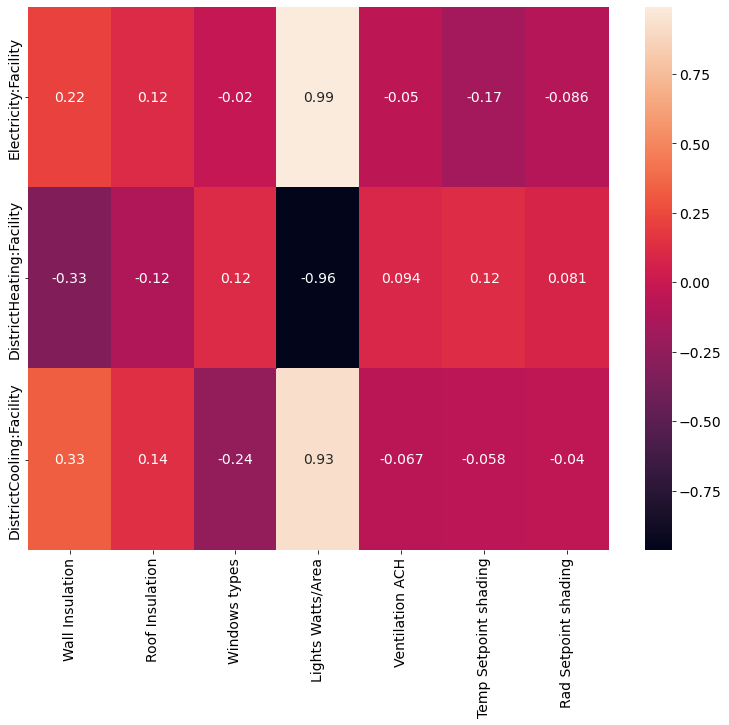

In [182]:
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)

In [183]:
df['Total'] = df['Electricity:Facility'] + df['DistrictHeating:Facility'] + df['DistrictCooling:Facility']
df['Dist'] = df.apply(lambda row : np.sqrt(pow(row["DistrictCooling:Facility"],2) + pow(row["DistrictHeating:Facility"],2) + pow(row["Electricity:Facility"],2)),axis=1)

df[df.Dist == df.Dist.min()]


Wall Insulation  Roof Insulation  Windows types  Lights Watts/Area  \
3732         0.157709         0.044256              3          15.117875   

      Ventilation ACH  Temp Setpoint shading  Rad Setpoint shading  \
3732         5.903477              28.849077            289.777089   

      ShadingWindowType  Electricity:Facility  DistrictHeating:Facility  \
3732                  3          1.099929e+11              2.551449e+10   

      DistrictCooling:Facility         Total          Dist  
3732              8.609317e+10  2.216005e+11  1.419910e+11

In [184]:
optimal_params=df.loc[df.Dist == df.Dist.min(),features].to_dict('records')[0]
optimal_params

{'Wall Insulation': 0.15770928707172172,
 'Roof Insulation': 0.04425579304907618,
 'Windows types': 3,
 'Lights Watts/Area': 15.117874560966632,
 'Ventilation ACH': 5.903477183758741,
 'Temp Setpoint shading': 28.849076697058265,
 'Rad Setpoint shading': 289.77708879883016,
 'ShadingWindowType': 3}

In [185]:
lights_selector.set(building,optimal_params['Lights Watts/Area'])
roof_ins.set(building,optimal_params['Roof Insulation'])
wall_ins.set(building,optimal_params['Wall Insulation'])
shade_setpoint_sel.set(building,optimal_params['Temp Setpoint shading'])
shade_setpoint2_sel.set(building,optimal_params['Rad Setpoint shading'])
ventACH_sel.set(building,optimal_params['Ventilation ACH'])

In [186]:
#selection of windows parameters
win_type = 'Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 1001'
for fenestration in building.idfobjects["FenestrationSurface:Detailed"]:
     if fenestration.obj[2] == "Window":
        win_sel = FieldSelector(class_name ='FenestrationSurface:Detailed', 
                            object_name = fenestration.Name, 
                            field_name='Construction Name' )
        win_sel.set(building,win_type)

In [187]:
shadingwindow_type = 'Trp LoE (e2=e5=.1) Clr 3mm/13mm Air - 2003'
for shadingtype in building.idfobjects['WINDOWSHADINGCONTROL']:
    sel_shading = FieldSelector(class_name='WINDOWSHADINGCONTROL', object_name = shadingtype.Name,\
                                field_name='Construction with Shading Name')
    sel_shading.set(building,shadingwindow_type)

In [188]:
building.saveas('lab_optimal.idf')